In [51]:
# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Funções utilitárias
from functools import reduce
from pathlib import Path
import json

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - pré-processamento, clustering e métricas
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [52]:
# Carregar dataset
df = pd.read_csv(
    r"C:\Users\A200068494\Downloads\ENTERPRISE_CHALLENGE_CLICKBUS\nextrip_ai\data_raw\df_t.csv"
)

In [53]:
base = Path.cwd().parent  # ...\nextrip_ai

# 1)	Entender e padronizar as colunas base

In [ ]:
# Convertendo colunas data
df["date_purchase"] = pd.to_datetime(df["date_purchase"], format="%Y-%m-%d")
df["time_purchase"] = pd.to_datetime(df["time_purchase"], format="%H:%M:%S").dt.time

# Convertendo colunas numéricas
df["gmv_success"] = df["gmv_success"].astype(float)
df["total_tickets_quantity_success"] = df["total_tickets_quantity_success"].astype(int)

In [ ]:
# Convertendo colunas string
df["nk_ota_localizer_id"] = df["nk_ota_localizer_id"].astype("string")
df["fk_contact"] = df["fk_contact"].astype("string")
df["place_origin_departure"] = df["place_origin_departure"].astype("string")
df["place_destination_departure"] = df["place_destination_departure"].astype("string")
df["place_origin_return"] = df["place_origin_return"].astype("string")
df["place_destination_return"] = df["place_destination_return"].astype("string")


df["fk_departure_ota_bus_company"] = df["fk_departure_ota_bus_company"].astype("string")
df["fk_return_ota_bus_company"] = df["fk_return_ota_bus_company"].astype("string")

In [ ]:
# Padronizando dados inexistentes
df["place_origin_return"] = df["place_origin_return"].replace("0", pd.NA)
df["place_destination_return"] = df["place_destination_return"].replace("0", pd.NA)
df["fk_return_ota_bus_company"] = df["fk_return_ota_bus_company"].replace("1", pd.NA)

In [ ]:
# Indicador binário se a compra tem viagem de volta
df["has_return"] = df["place_origin_return"].notna().astype(int)

# Na rota de IDA, junta origem e destino em uma única string (facilita contar e agrupar por rota)
df["route_out"] = (
    df["place_origin_departure"] + "__" + df["place_destination_departure"]
)

# Na rota de VOLTA, junta origem e destino em uma única string (facilita contar e agrupar por rota)
df["route_return"] = df.apply(
    lambda x: (
        f"{x['place_origin_return']}__{x['place_destination_return']}"
        if x["has_return"]
        else None
    ),
    axis=1,
)

In [58]:
# Dataframe APENAS com registros duplicados
dupes = df[df.duplicated(subset=["nk_ota_localizer_id"], keep=False)]

In [59]:
print("Data mínima:", df["date_purchase"].min())
print("Data máxima:", df["date_purchase"].max())
print("Hora mínima:", df["time_purchase"].min())
print("Hora máxima:", df["time_purchase"].max())
print("Valor total mínimo do ticket:", df["gmv_success"].min())
print("Valor total máximo do ticket:", df["gmv_success"].max())
print("Qtd mínima tickets:", df["total_tickets_quantity_success"].min())
print("Qtd máxima tickets:", df["total_tickets_quantity_success"].max())

Data mínima: 2013-09-12 00:00:00
Data máxima: 2024-04-01 00:00:00
Hora mínima: 00:00:00
Hora máxima: 23:59:59
Valor total mínimo do ticket: -3656.57
Valor total máximo do ticket: 6723.93
Qtd mínima tickets: 1
Qtd máxima tickets: 16


In [60]:
# Filtra casos onde has_return = 1 mas total_tickets_quantity_success < 2
violacoes = df[(df["has_return"] == 1) & (df["total_tickets_quantity_success"] < 2)]

print(f"Número de violações: {len(violacoes)}")

Número de violações: 31


In [61]:
# Indicador binário se a compra tem viagem de volta, agora mais restritivo
## garante que existe origem e destino para a volta e regra de negócio "ida e volta = no mínimo, 2 tickets"
df["has_return"] = (
    df["place_origin_return"].notna()
    & df["place_destination_return"].notna()
    & (df["total_tickets_quantity_success"] >= 2)
).astype(int)

# 2)	Limpeza & normalização (ETL)

In [ ]:
# Cria dataframe APENAS com gmv negativos
df_gmv_negative = df[df["gmv_success"] < 0]

# Remove valores negativos, assim trabalhamos com situações reais
df = df[df["gmv_success"] > 0]

In [64]:
# Indicação se a compra foi feita no final de semana
df["is_weekend"] = df["date_purchase"].dt.dayofweek >= 5

In [65]:
# Garantir que não teremos registros sem nenhuma passagem emitida
df = df[df["total_tickets_quantity_success"] > 0]

In [ ]:
# Criando a métrica "avg_price_per_ticket", preço médio por passageiro
df["avg_price_per_ticket"] = df["gmv_success"] / df["total_tickets_quantity_success"]


# Calcula o percentil 99, valor que separa os 1% mais caros do restante


p99 = df["avg_price_per_ticket"].quantile(0.99)

# Remove todas as compras com "avg_price_per_ticket" acima deste limite


df_clean = df[df["avg_price_per_ticket"] <= p99]

In [67]:
destino_pc = base / "data_intermediate" / "purchases_clean.parquet"
destino_pc.parent.mkdir(parents=True, exist_ok=True)

df_clean.to_parquet(destino_pc, index=False)

# 3)	Janela de observação

Futuramente é possível implementar uma janela de observação móvel.

In [ ]:
# Data de execução (mudar para dinâmico futuramente)
build_date = pd.to_datetime("2024-01-01")
# Janela de meses observados, pode ser 6, 12, 24 ou 36 (mais comuns)
janela_meses = 12

In [ ]:
# Calculando qual a data de início da janela
start_date = build_date - pd.DateOffset(months=janela_meses)

# Criando dataframe da janela de observação
df_window = df_clean[
    (df_clean["date_purchase"] >= start_date)
    & (df_clean["date_purchase"] <= build_date)
]

In [ ]:
destino_pcw = (
    base / "data_intermediate" / f"purchases_clean_window_{janela_meses}m.parquet"
)
destino_pcw.parent.mkdir(parents=True, exist_ok=True)

df_window.to_parquet(destino_pcw, index=False)

# 4)	Engenharia de atributos por cliente (customer_features.parquet)

In [71]:
df_cf = pd.read_parquet(
    r"C:\Users\A200068494\Downloads\ENTERPRISE_CHALLENGE_CLICKBUS\nextrip_ai\data_intermediate\purchases_clean_window_12m.parquet"
)

In [72]:
# Criando objeto de agrupamento por cliente
g = df_cf.groupby("fk_contact")

**(A) RFM (Recency, Frequency, Monetary)**

In [ ]:
# Features: comportamento de compra e valor gasto
### Recência de compra (quantos dias desde a última compra)
### Frequência de compras no período (quantidade de pedidos distintos)
### Valor total gasto (GMV) no período
### Ticket médio por compra (valor médio gasto em cada pedido)

rfm = g.agg(
    last_purchase=("date_purchase", "max"),
    frequency_12m=("nk_ota_localizer_id", "nunique"),
    monetary_gmv_12m=("gmv_success", "sum"),  # valor total gasto no período
).reset_index()

# Calcular dias desde última compra
rfm["recency_days"] = (build_date - rfm["last_purchase"]).dt.days

# Calcular ticket médio
rfm["avg_ticket_value"] = rfm["monetary_gmv_12m"] / rfm["frequency_12m"]

**(B) Estrutura de viagem**

In [ ]:
# Features: diversidade de destinos e fidelidade de rota
### Fidelidade ao tipo de viagem (ida+volta X só ida)
### Diversidade geográfica (quantas rotas diferentes o cliente fez)
routes = g.agg(
    pct_round_trip=("has_return", "mean"),  # percentual de compras com ida e volta
    n_unique_routes_out=("route_out", "nunique"),  # número de rotas de ida distintas
).reset_index()

# Contar viagens por rota para cada cliente
route_counts = (
    df_cf.groupby(["fk_contact", "route_out"])["nk_ota_localizer_id"]
    .nunique()
    .reset_index(name="cnt")
)

# Seleciona a rota mais usada de cada cliente
idx = route_counts.groupby("fk_contact")["cnt"].idxmax()
top_route = route_counts.loc[idx, ["fk_contact", "route_out", "cnt"]]

# Calcular o total de compras em todas as rotas
tot_cnt = (
    route_counts.groupby("fk_contact")["cnt"].sum().reset_index(name="tot_cnt")
)  # rota top

# Calcular a participação da rota top


top_route = top_route.merge(tot_cnt, on="fk_contact")


top_route["top_route_out_share"] = top_route["cnt"] / top_route["tot_cnt"]

# Ajusta nomes e colunas finais


top_route.rename(columns={"route_out": "top_route_out"}, inplace=True)


top_route.drop(columns=["cnt", "tot_cnt"], inplace=True)

**(C) Companhia preferida**

In [75]:
# Features: fidelidade à viação
### Viação mais utilizada pelo cliente (identificador da companhia de ônibus preferida)
### Grau de lealdade à viação (percentual de compras feitas com a companhia mais usada)

# Contar compras por viação para cada cliente
company_counts = (
    g.apply(
        lambda d: d.groupby("fk_departure_ota_bus_company")[
            "nk_ota_localizer_id"
        ].nunique()
    )
    .rename("cnt")
    .reset_index()
)

# Selecionar a viação mais usada de cada cliente
idx = company_counts.groupby("fk_contact")["cnt"].idxmax()
top_company = company_counts.loc[
    idx, ["fk_contact", "fk_departure_ota_bus_company", "cnt"]
]

# Calcular o total de compras em todas as viações
tot_cnt = company_counts.groupby("fk_contact")["cnt"].sum().reset_index(name="tot_cnt")

# Calcular o share da viação top
top_company = top_company.merge(tot_cnt, on="fk_contact")
top_company["top_company_out_share"] = (
    top_company["cnt"] / top_company["tot_cnt"]
)  # percentual de lealdade à viação mais usada

# Ajustar nomes das colunas finais
top_company.rename(
    columns={"fk_departure_ota_bus_company": "top_company_out"}, inplace=True
)
top_company.drop(columns=["cnt", "tot_cnt"], inplace=True)

C:\Users\A200068494\AppData\Local\Temp\ipykernel_24632\4237290059.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g.apply(


**(D) Sazonalidade de compra**

In [ ]:
# Features: sazonalidade de compra
### Compras em fim de semana (percentual de compras feitas aos sábados e domingos)
### Distribuição por trimestre (percentual de compras no Q1, Q2, Q3 e Q4)
### Distribuição por estação ###
### Distribuição por horário do dia ###
### Distribuição por mês ###
### Distribuição por feriado/período festivo ###

# Cria flag de compras feitas no fim de semana
df_cf["is_weekend"] = df_cf["date_purchase"].dt.dayofweek >= 5

# Calcula percentual de compras no fim de semana
weekend_share = g["is_weekend"].mean().reset_index(name="pct_weekend_purchases")


# Extrai trimestre da compra
df_cf["quarter"] = df_cf["date_purchase"].dt.quarter

# Calcula distribuição das compras por trimestre
quarter_dist = pd.crosstab(
    df_cf["fk_contact"], df_cf["quarter"], normalize="index"
).reset_index()


quarter_dist.columns = ["fk_contact", "pct_q1", "pct_q2", "pct_q3", "pct_q4"]

In [77]:
# 2) Sazonalidade por estação (hemisfério sul)
#    Verão: Dez–Fev | Outono: Mar–Mai | Inverno: Jun–Ago | Primavera: Set–Nov
def month_to_season_south(m):
    if m in (12, 1, 2):
        return "verao"
    elif m in (3, 4, 5):
        return "outono"
    elif m in (6, 7, 8):
        return "inverno"
    else:
        return "primavera"


df_cf["month"] = df_cf["date_purchase"].dt.month
df_cf["season"] = df_cf["month"].apply(month_to_season_south)

season_dist = (
    pd.crosstab(df_cf["fk_contact"], df_cf["season"], normalize="index")
    .reset_index()
    .rename(
        columns={
            "verao": "pct_verao",
            "outono": "pct_outono",
            "inverno": "pct_inverno",
            "primavera": "pct_primavera",
        }
    )
)

In [78]:
# 3) Sazonalidade por horário do dia
#    (noite 0–6), manhã 6–12, tarde 12–18, noite 18–24

# Extrai hora de forma robusta
if "time_purchase" in df_cf.columns:
    # Se vier como string "HH:MM:SS"
    try:
        hhmm = pd.to_datetime(
            df_cf["time_purchase"], format="%H:%M:%S", errors="coerce"
        )
        hours = hhmm.dt.hour
        # fallback se time_purchase estiver vazio: usa date_purchase
        hours = hours.fillna(df_cf["date_purchase"].dt.hour)
    except Exception:
        hours = df_cf["date_purchase"].dt.hour
else:
    hours = df_cf["date_purchase"].dt.hour


def hour_bin(h):
    # inclui a madrugada como "noite_1" para separar noite inicial e final, se quiser
    if 6 <= h < 12:
        return "manha"
    elif 12 <= h < 18:
        return "tarde"
    elif 18 <= h <= 23:
        return "noite"
    else:
        return "madrugada"


df_cf["daypart"] = hours.apply(hour_bin)

daypart_dist = (
    pd.crosstab(df_cf["fk_contact"], df_cf["daypart"], normalize="index")
    .reset_index()
    .rename(
        columns={
            "madrugada": "pct_madrugada",
            "manha": "pct_manha",
            "tarde": "pct_tarde",
            "noite": "pct_noite",
        }
    )
)

In [79]:
# 4) Sazonalidade por mês (12 colunas)
month_dist = pd.crosstab(
    df_cf["fk_contact"], df_cf["month"], normalize="index"
).reset_index()
# renomeia colunas 1..12 -> pct_m01..pct_m12
month_map = {m: f"pct_m{m:02d}" for m in range(1, 13)}
month_dist = month_dist.rename(columns=month_map)

In [81]:
# 6) Feriados / Períodos festivos
#    Opção A: feriados nacionais com a lib 'holidays' (pip install holidays)
#    Opção B: janelas personalizadas (Carnaval estendido, Natal/Reveillon, etc.)
# ---------------------------------------------------------
try:
    import holidays

    # Brasil inteiro; ajuste years se quiser otimizar performance
    years = pd.unique(df_cf["date_purchase"].dt.year).tolist()
    br_holidays = holidays.country_holidays("BR", years=years)
    df_cf["is_holiday"] = df_cf["date_purchase"].dt.date.isin(br_holidays)

    # Exemplo de "períodos festivos" customizados:
    # - Jan: até 06/Jan (Reis) como alta temporada residual
    # - Carnaval: janela de 5 dias centrada na 3ª de carnaval (se existir no dict)
    # - Jun: festa junina (mês todo como sinal fraco)
    # - Dez 20 – Jan 5: Natal/Reveillon (janela forte)
    d = df_cf["date_purchase"].dt.date
    y = df_cf["date_purchase"].dt.year

    # Natal/Reveillon estendido
    nat_reveillon = (
        df_cf["date_purchase"].dt.month.eq(12) & (df_cf["date_purchase"].dt.day >= 20)
    ) | (df_cf["date_purchase"].dt.month.eq(1) & (df_cf["date_purchase"].dt.day <= 5))

    # Festa junina (junho inteiro)
    festa_junina = df_cf["date_purchase"].dt.month.eq(6)

    # Carnaval (se existir data no pacote de feriados)
    def is_carnaval_window(ts):
        # janela de +/- 2 dias ao redor da Terça de Carnaval (se disponível)
        dt = ts.date()
        year = ts.year
        # encontra uma entrada com 'Carnaval' no dicionário daquele ano
        c_dates = [
            h
            for h, name in br_holidays.items()
            if (h.year == year and "Carnaval" in str(name))
        ]
        if len(c_dates) == 0:
            return False
        cday = c_dates[0]
        return abs((dt - cday).days) <= 2

    carnaval_win = df_cf["date_purchase"].apply(is_carnaval_window)

    df_cf["is_festive_period"] = (
        df_cf["is_holiday"] | nat_reveillon | festa_junina | carnaval_win
    )

except Exception:
    # fallback sem a lib 'holidays': somente períodos simples
    df_cf["is_holiday"] = False
    nat_reveillon = (
        df_cf["date_purchase"].dt.month.eq(12) & (df_cf["date_purchase"].dt.day >= 20)
    ) | (df_cf["date_purchase"].dt.month.eq(1) & (df_cf["date_purchase"].dt.day <= 5))
    festa_junina = df_cf["date_purchase"].dt.month.eq(6)
    df_cf["is_festive_period"] = nat_reveillon | festa_junina

# Percentuais por cliente
holiday_share = (
    df_cf.groupby("fk_contact")[["is_holiday", "is_festive_period"]]
    .mean()
    .reset_index()
    .rename(
        columns={
            "is_holiday": "pct_holiday_purchases",
            "is_festive_period": "pct_festive_period_purchases",
        }
    )
)

In [82]:
feature_frames = [
    weekend_share,
    quarter_dist,
    season_dist,
    daypart_dist,
    month_dist,
    dow_dist,
    wom_dist,
    holiday_share,
]

features_sazonalidade = reduce(
    lambda left, right: pd.merge(left, right, on="fk_contact", how="outer"),
    feature_frames,
).fillna(0.0)

**(E) Intensidade de consumo**

In [ ]:
# Features: intensidade de consumo
### Volume de passagens emitidas (total de bilhetes comprados no período)
### Preço médio por passagem (valor total gasto dividido pelo total de bilhetes)

# Somar total de passagens emitidas no período
intensity = g.agg(
    total_tickets_12m=("total_tickets_quantity_success", "sum")
).reset_index()

# Calcular preço médio por passagem, considera o valor unitário de cada passagem


intensity["avg_price_per_ticket"] = (
    rfm["monetary_gmv_12m"] / intensity["total_tickets_12m"]
)

In [ ]:
# Criando dataframe com features
dfs_to_merge = [
    rfm[
        [
            "fk_contact",
            "recency_days",
            "frequency_12m",
            "monetary_gmv_12m",
            "avg_ticket_value",
        ]
    ],
    routes,
    top_route,
    top_company,
    features_sazonalidade,
    intensity,
]


features = reduce(
    lambda left, right: pd.merge(left, right, on="fk_contact", how="left"), dfs_to_merge
)

In [85]:
features.fillna(0, inplace=True)
features["build_date"] = build_date.strftime("%Y-%m-%d")
features["model_version"] = "segm_v0.1"

In [86]:
destino_cf = base / "data_products" / "features/customer_features.parquet"
destino_cf.parent.mkdir(parents=True, exist_ok=True)

features.to_parquet(destino_cf, index=False)

# 5)	Padronização para clustering

In [87]:
features.columns

Index(['fk_contact', 'recency_days', 'frequency_12m', 'monetary_gmv_12m',
       'avg_ticket_value', 'pct_round_trip', 'n_unique_routes_out',
       'top_route_out', 'top_route_out_share', 'top_company_out',
       'top_company_out_share', 'pct_weekend_purchases', 'pct_q1', 'pct_q2',
       'pct_q3', 'pct_q4', 'pct_inverno', 'pct_outono', 'pct_primavera',
       'pct_verao', 'pct_madrugada', 'pct_manha', 'pct_noite', 'pct_tarde',
       'pct_m01', 'pct_m02', 'pct_m03', 'pct_m04', 'pct_m05', 'pct_m06',
       'pct_m07', 'pct_m08', 'pct_m09', 'pct_m10', 'pct_m11', 'pct_m12',
       'pct_seg', 'pct_ter', 'pct_qua', 'pct_qui', 'pct_sex', 'pct_sab',
       'pct_dom', 'pct_wom1', 'pct_wom2', 'pct_wom3', 'pct_wom4', 'pct_wom5',
       'pct_holiday_purchases', 'pct_festive_period_purchases',
       'total_tickets_12m', 'avg_price_per_ticket', 'build_date',
       'model_version'],
      dtype='object')

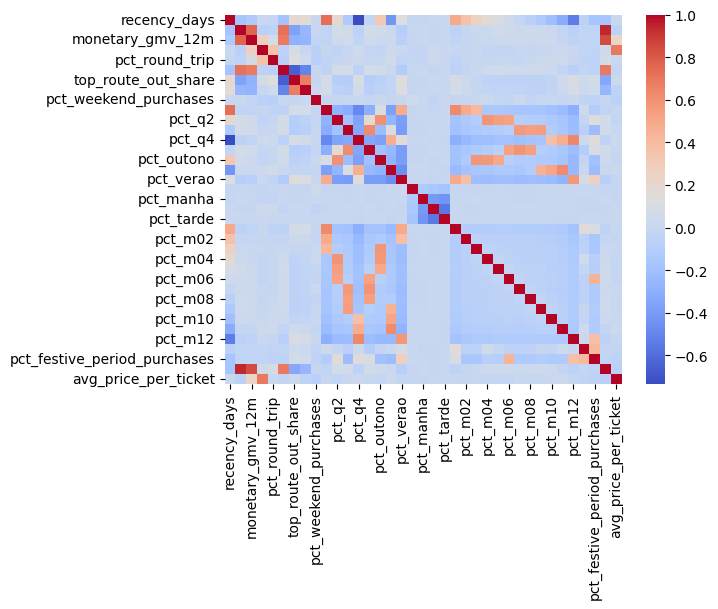

In [ ]:
# Análise exploratória e testes para definir features
use_cols = [
    "recency_days",
    "frequency_12m",
    "monetary_gmv_12m",
    "avg_ticket_value",
    "pct_round_trip",
    "n_unique_routes_out",
    "top_route_out_share",
    "top_company_out_share",
    "pct_weekend_purchases",
    "pct_q1",
    "pct_q2",
    "pct_q3",
    "pct_q4",
    "pct_inverno",
    "pct_outono",
    "pct_primavera",
    "pct_verao",
    "pct_madrugada",
    "pct_manha",
    "pct_noite",
    "pct_tarde",
    "pct_m01",
    "pct_m02",
    "pct_m03",
    "pct_m04",
    "pct_m05",
    "pct_m06",
    "pct_m07",
    "pct_m08",
    "pct_m09",
    "pct_m10",
    "pct_m11",
    "pct_m12",
    "pct_seg",
    "pct_ter",
    "pct_qua",
    "pct_qui",
    "pct_sex",
    "pct_sab",
    "pct_dom",
    "pct_wom1",
    "pct_wom2",
    "pct_wom3",
    "pct_wom4",
    "pct_wom5",
    "pct_holiday_purchases",
    "pct_festive_period_purchases",
    "total_tickets_12m",
    "avg_price_per_ticket",
]

corr = features[use_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.show()

In [92]:
corr_rounded.to_excel("correlacao_features.xlsx")

In [90]:
corr_rounded = corr.round(2)
corr_rounded

,recency_days,frequency_12m,monetary_gmv_12m,avg_ticket_value,pct_round_trip,n_unique_routes_out,top_route_out_share,top_company_out_share,pct_weekend_purchases,pct_q1,...,pct_m07,pct_m08,pct_m09,pct_m10,pct_m11,pct_m12,pct_holiday_purchases,pct_festive_period_purchases,total_tickets_12m,avg_price_per_ticket
recency_days,1.00,-0.18,-0.13,0.01,-0.02,-0.18,0.19,0.17,0.01,0.73,...,-0.01,-0.07,-0.14,-0.21,-0.32,-0.54,-0.07,-0.17,-0.17,0.02
frequency_12m,-0.18,1.00,0.77,-0.08,-0.05,0.72,-0.36,-0.26,0.01,-0.04,...,0.03,0.04,0.03,0.02,-0.02,-0.07,-0.02,-0.04,0.94,-0.07
monetary_gmv_12m,-0.13,0.77,1.00,0.27,0.07,0.69,-0.29,-0.27,-0.03,-0.04,...,0.02,0.03,0.03,0.02,-0.01,-0.05,-0.03,-0.04,0.85,0.22
avg_ticket_value,0.01,-0.08,0.27,1.00,0.36,-0.06,0.08,-0.00,-0.07,-0.00,...,0.00,-0.01,0.00,0.02,0.03,0.01,-0.03,-0.04,0.04,0.69
pct_round_trip,-0.02,-0.05,0.07,0.36,1.00,-0.08,0.13,0.05,-0.08,-0.04,...,-0.01,0.01,0.02,0.03,0.03,-0.01,-0.03,-0.05,0.07,0.01
n_unique_routes_out,-0.18,0.72,0.69,-0.06,-0.08,1.00,-0.66,-0.51,-0.00,-0.05,...,0.03,0.04,0.04,0.02,-0.03,-0.07,-0.03,-0.04,0.69,-0.02
top_route_out_share,0.19,-0.36,-0.29,0.08,0.13,-0.66,1.00,0.68,-0.01,0.07,...,-0.05,-0.05,-0.06,-0.03,0.04,0.10,0.03,0.06,-0.34,0.03
top_company_out_share,0.17,-0.26,-0.27,-0.00,0.05,-0.51,0.68,1.00,0.01,0.06,...,-0.04,-0.05,-0.04,-0.03,0.02,0.07,0.02,0.05,-0.26,-0.05
pct_weekend_purchases,0.01,0.01,-0.03,-0.07,-0.08,-0.00,-0.01,0.01,1.00,-0.00,...,0.02,-0.02,0.00,0.01,-0.02,0.02,-0.04,-0.05,-0.00,-0.07
pct_q1,0.73,-0.04,-0.04,-0.00,-0.04,-0.05,0.07,0.06,-0.00,1.00,...,-0.17,-0.17,-0.18,-0.19,-0.23,-0.30,0.04,-0.10,-0.04,-0.01


In [34]:
# Lista das features finais escolhidas para o modelo de clusterização (já depois da análise de correlação e seleção).
cluster_var = [
    "frequency_12m",  # frequencia
    "n_unique_routes_out",  # diversidade de rotas
    "avg_price_per_ticket",  # preço médio
    "top_route_out_share",  # fidelidade à rota principal
    "top_company_out_share",  # fidelidade à viação
]

In [ ]:
# Colunas para aplicar log (tem distribuição muito assimétrica)
log_cols = [
    "monetary_gmv_12m",
    "avg_ticket_value",
    "total_tickets_12m",
    "avg_price_per_ticket",
]

# Aplicar log, reduzindo a assimetria e diminuindo o peso de outliers no treinamento
for col in log_cols:
    features[col] = np.log1p(features[col])

In [36]:
# Preenchendo valores ausentes para garntir que não haverá erro no K-Means
features[cluster_var] = features[cluster_var].fillna(0)

In [ ]:
# Preparando os dados para o clustering com z-score
# Criando o objeto StandardScaler (transforma cada variável para ter média 0 e desvio padrão 1)
scaler = StandardScaler()

# Ajustar e transformar os dados (calcula a média e o desvio padrão de cada coluna)
X = scaler.fit_transform(features[cluster_var])
# Guarda os nomes das colunas e estatísticas para reuso
scaler_mean = scaler.mean_
scaler_scale = scaler.scale_

In [ ]:
# Salvando a versão padronizada das features por cliente
# Criar dataframe com dados padronizados
X_df = pd.DataFrame(X, columns=cluster_var)
X_df["fk_contact"] = features["fk_contact"]

destino_cfs = base / "data_intermediate" / "customer_features_standardized.parquet"
destino_cfs.parent.mkdir(parents=True, exist_ok=True)
X_df.to_parquet(destino_cfs, index=False)

# 6)	Treinamento do modelo de segmentação

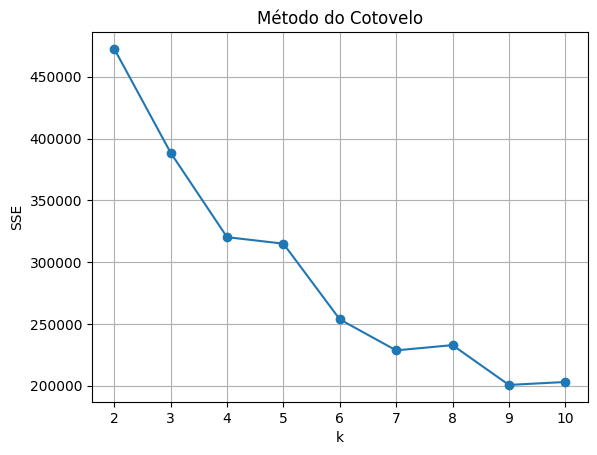

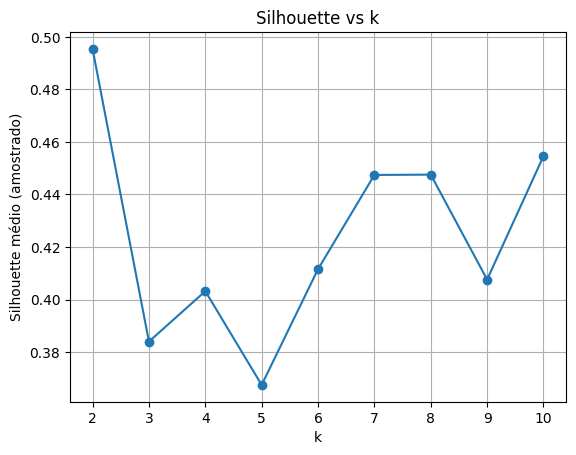

In [ ]:
# Busca do número ideal de clusters (k)  usando SSE e Sillhouette Score

# Garantindo padronização das features


X_scaled = StandardScaler().fit_transform(X)


# Definindo faixa de k a testar


K_range = range(2, 11)


sse = []  # armazena SSE


sil = []  # armazena sillhouette médio


# Usano MiniBatchKMeans para acelerar o teste (processamento em lote)


use_minibatch_for_elbow = X_scaled.shape[0] > 100_000


# Loop para treinar o K-Means/MiniBatchKMeans


for k in K_range:

    if use_minibatch_for_elbow:

        km_elbow = MiniBatchKMeans(
            n_clusters=k, batch_size=2048, max_iter=100, n_init=5, random_state=42
        ).fit(X_scaled)

        sse.append(km_elbow.inertia_)

        labels = km_elbow.labels_

    else:

        km = KMeans(
            n_clusters=k, algorithm="elkan", max_iter=150, n_init=5, random_state=42
        ).fit(X_scaled)

        sse.append(km.inertia_)

        labels = km.labels_

    # Calcular Sillhouette médio (com amostragem), mede a separação e coesão dos clusters
    sil.append(
        silhouette_score(
            X_scaled,
            labels,
            metric="euclidean",
            sample_size=min(5000, X_scaled.shape[0]),
            random_state=42,
        )
    )


# Plots (sem estilos especiais)
## Procura o ponto onde a curva do SSE começa a achatar


plt.plot(list(K_range), sse, marker="o")


plt.xlabel("k")


plt.ylabel("SSE")


plt.title("Método do Cotovelo")


plt.grid(True)


plt.show()


## Procura picos (quanto mais próximo de 1, melhor)


plt.plot(list(K_range), sil, marker="o")


plt.xlabel("k")


plt.ylabel("Silhouette médio (amostrado)")


plt.title("Silhouette vs k")


plt.grid(True)


plt.show()

In [ ]:
# Treinar o modelo com k=5 (após análise)
k = 5


km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)


km.fit(X)  # matriz padronizada das features


# Obter rótulos dos clusters


labels = km.labels_  # no caso, de 0 a 4

# Extrair centróides no espaço padronizado
## cada linha = um cluster
## cada coluna = média das features na escala z-score


centroids = km.cluster_centers_

In [ ]:
# Reverter centróides para a escala original
centroids_unscaled = scaler.inverse_transform(centroids)


centroids_df = pd.DataFrame(
    centroids_unscaled, columns=cluster_var
)  # mostra valores médios originais de cada feature por cluster

In [ ]:
# Calcular média geral de cada feature na base
mean_all = features[cluster_var].mean()

# Calcular desvio padrão global de cada feature


std_all = features[cluster_var].std()


# Calcular diferença dos centróides para a média geral
## útil para classificar cada feature em "Alto / Médio / Baixo"


diffs = centroids_df - mean_all

In [43]:
cluster_name_map = {
    0: "Frequente e diversificado • Pouca lealdade",
    1: "Pouca frequência • Ticket alto • Alta lealdade",
    2: "Pouca frequência • Ticket baixo • Alta lealdade",
    3: "Frequência média • Lealdade baixa",
    4: "Extrema frequência • Altíssima diversidade • Pouca lealdade",
}

In [44]:
# Criar base de atribuição cliente -> cluster
assign = features[["fk_contact"]].copy()


assign["cluster_id"] = labels

# Adicionar nome legível do cluster
assign["cluster_name"] = assign["cluster_id"].map(cluster_name_map)  # se já nomeados

# Adicionar metadados
assign["build_date"] = build_date.strftime("%Y-%m-%d")
assign["model_version"] = "segm_v0.1"

destino_ca = base / "data_products" / "clusters/cluster_assignments.csv"

destino_ca.parent.mkdir(parents=True, exist_ok=True)

assign.to_csv(destino_ca, index=False)

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\A200068494\\Downloads\\ENTERPRISE_CHALLENGE_CLICKBUS\\nextrip_ai\\data_products\\clusters\\cluster_assignments.csv'

# 7)	Nomear clusters (rótulos legíveis)

In [ ]:
def classify_diff(val, mean, std):
    if val - mean > std:
        return "Alto"
    elif val - mean < -std:
        return "Baixo"
    else:
        return "Médio"


# Criar DataFrame de classificações
classifications = centroids_df[cluster_var].copy()

for col in cluster_var:
    classifications[col] = classifications[col].apply(
        lambda x: classify_diff(x, mean_all[col], std_all[col])
    )

# 8)	Gerar os 4 artefatos do MVP

In [ ]:
# cluster_assignments.csv
destino_ca = base / "data_products" / "clusters" / "cluster_assignments.csv"
destino_ca.parent.mkdir(parents=True, exist_ok=True)
assign.to_csv(destino_ca, index=False)

In [ ]:
# cluster_centroids.json
# Medianas por cluster calculadas a partir das features originais dos clientes
features_w_cluster = features.copy()
features_w_cluster["cluster_id"] = labels

medians_cluster = (
    features_w_cluster.groupby("cluster_id")[cluster_var]
    .median()
    .reset_index(drop=True)
)

payload = {
    "model_version": "segm_v0.1",
    "build_date": build_date.strftime("%Y-%m-%d"),  # <-- corrigido (string)
    "feature_order": cluster_var,  # lista de features usadas no treinamento
    "standardized": centroids.tolist(),  # centróides no espaço padronizado (z-score)
    "original_scale_means": centroids_df.to_dict(  # <-- por cluster (centróides revertidos)
        orient="records"
    ),
    "original_scale_medians": medians_cluster.to_dict(  # <-- por cluster (medianas reais)
        orient="records"
    ),
}

destino_cc = base / "data_products" / "clusters" / "cluster_centroids.json"
destino_cc.parent.mkdir(parents=True, exist_ok=True)
with open(destino_cc, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

In [ ]:
# customer_features.parquet
destino_cf = base / "data_products" / "features" / "customer_features.parquet"
destino_cf.parent.mkdir(parents=True, exist_ok=True)
features.to_parquet(destino_cf, index=False)

In [ ]:
# cluster_summary.xlsx

# Junta compras da janela com o cluster de cada cliente
df_sum = df_cf.merge(
    assign[["fk_contact", "cluster_id", "cluster_name"]], on="fk_contact", how="left"
)

# Overview inicial (algumas métricas brutas)
overview = (
    df_sum.groupby(["cluster_id", "cluster_name"])
    .agg(
        clientes=("fk_contact", "nunique"),  # nº de clientes únicos no cluster
        gmv=("gmv_success", "sum"),  # soma do GMV de todas as compras do cluster
        ticket_medio=("gmv_success", "mean"),  # média de gmv_success por compra
        pedidos=(
            "nk_ota_localizer_id",
            "nunique",
        ),  # nº de pedidos distintos no cluster
    )
    .reset_index()
)

# Frequência média por cliente (= média de pedidos por cliente no cluster)
freq_cliente = (
    df_sum.groupby("fk_contact")["nk_ota_localizer_id"]
    .nunique()
    .rename("freq_cliente")
    .reset_index()
)

freq_cluster = (
    freq_cliente.merge(
        assign[["fk_contact", "cluster_name", "cluster_id"]],
        on="fk_contact",
        how="left",
    )
    .groupby(["cluster_id", "cluster_name"])["freq_cliente"]
    .mean()
    .reset_index(name="freq_media")
)

# Inserir freq_media correta
overview = overview.merge(
    freq_cluster, on=["cluster_id", "cluster_name"], how="left"
).drop(columns=["pedidos"])

# % clientes e % GMV
tot_cli = overview["clientes"].sum()
tot_gmv = overview["gmv"].sum()
overview["pct_clientes"] = overview["clientes"] / max(tot_cli, 1)
overview["pct_gmv"] = overview["gmv"] / max(tot_gmv, 1)

# Grava o Excel com diretório garantido
destino_xlsx = base / "data_products" / "reports" / "cluster_summary.xlsx"
destino_xlsx.parent.mkdir(parents=True, exist_ok=True)

with pd.ExcelWriter(destino_xlsx) as writer:
    # Overview executivo
    overview.to_excel(writer, sheet_name="Overview", index=False)

    # Top Rotas por cluster
    (
        df_sum.groupby(["cluster_name", "route_out"])["nk_ota_localizer_id"]
        .nunique()
        .reset_index(name="compras")
        .sort_values(["cluster_name", "compras"], ascending=[True, False])
        .groupby("cluster_name")
        .head(10)
        .to_excel(writer, sheet_name="TopRotas", index=False)
    )

    # Top Viações por cluster (ASCII no nome da aba)
    (
        df_sum.groupby(["cluster_name", "fk_departure_ota_bus_company"])[
            "nk_ota_localizer_id"
        ]
        .nunique()
        .reset_index(name="compras")
        .sort_values(["cluster_name", "compras"], ascending=[True, False])
        .groupby("cluster_name")
        .head(10)
        .to_excel(writer, sheet_name="TopViacoes", index=False)
    )

    # Glossário (ASCII no nome da aba)
    pd.DataFrame(
        {
            "Glossario": [
                "Clientes: número de clientes únicos no cluster",
                "GMV: soma do valor de passagens no cluster",
                "Ticket médio: valor médio por compra",
                "Frequência média: média de compras por cliente",
            ]
        }
    ).to_excel(writer, sheet_name="Glossario", index=False)